In [2]:
from load_dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import smogn

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import warnings

load_dotenv()
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [19]:
dataset_path = os.environ['mac_dataset_path']
df = pd.read_csv(dataset_path)
print('Unfiltered row of dataframe is {}'.format(len(df)))

Unfiltered row of dataframe is 727657


### This notebook focus will be on predicting ch_sysef using various features and some selections of models

total number of rows after filter is 176037


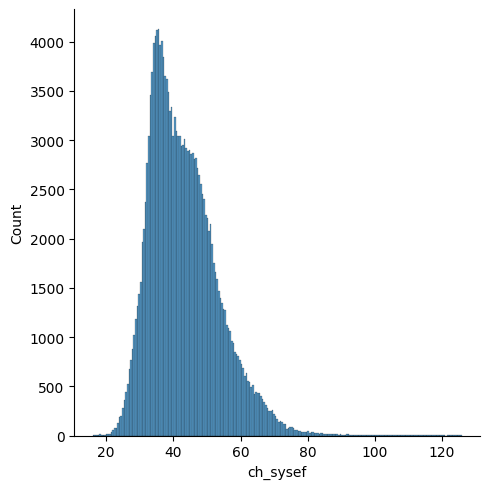

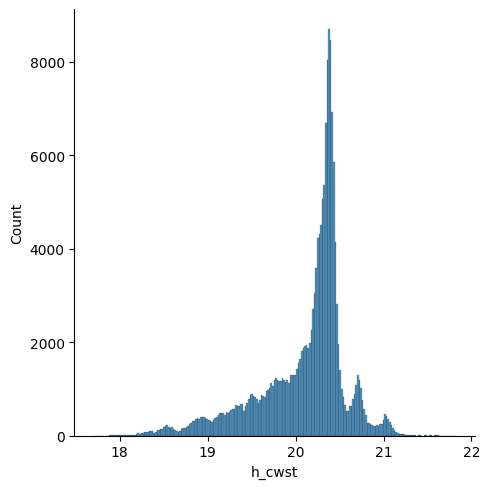

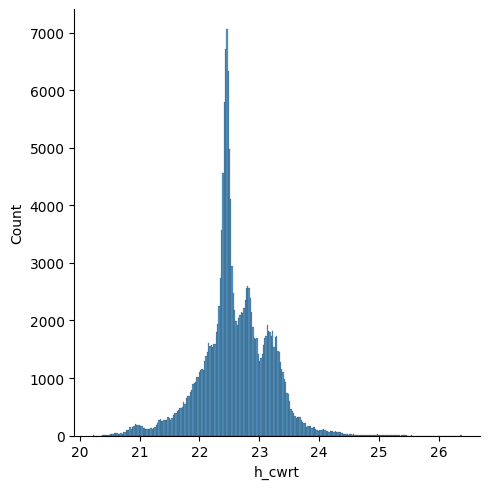

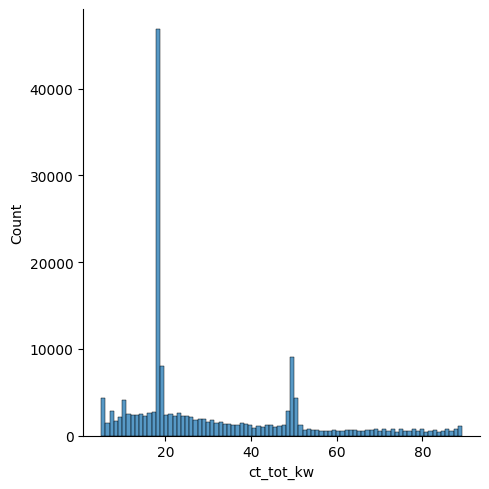

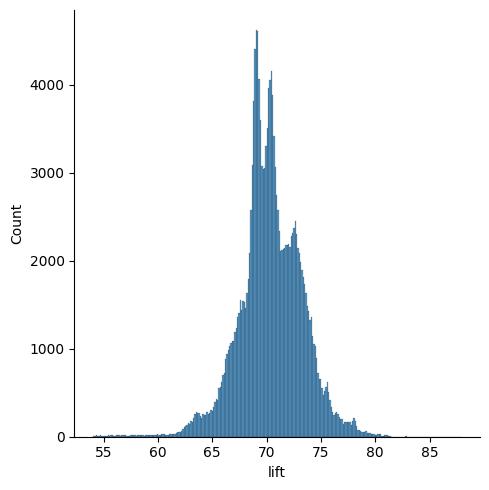

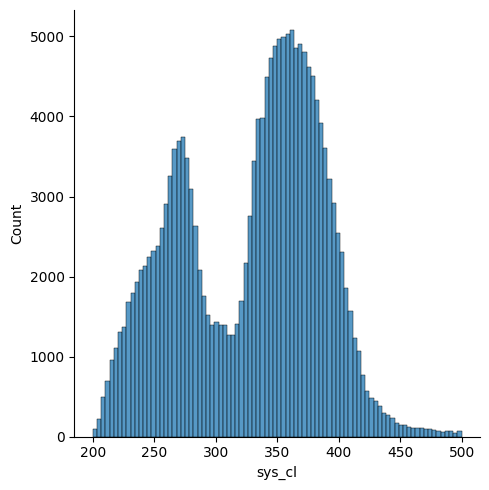

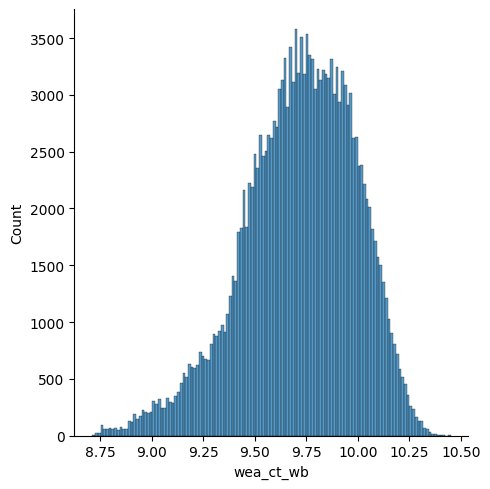

In [20]:
# filter where hr or hb is  not 0
df = df[(df['sys_hr'] != 0) | (df['sys_hb'] != 0)]
df = df[(df['h_chwst'] >=5) & (df['h_chwst'] <=20)]
df = df[(df['h_chwrt'] >=5) & (df['h_chwrt'] <=25)]
df = df[(df['pchwp_1_kw'] >=1.2) & (df['pchwp_1_kw'] <=5)]
# unsure of pchwp_2 kw filtering
#df = df[(df['pchwp_2_kw'] >=1.2) & (df['pchwp_2_kw'] <=5)]
df = df[(df['h_chwf'] >= 0) & (df['h_chwf'] <= 1500)]
df = df[(df['cwp_1_kw'] > 0) & (df['cwp_1_kw'] <=25)]
df = df[(df['cwp_2_kw'] > 0) & (df['cwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >0) & (df['h_chwf'] <=1500)]
df = df[(df['h_cwst']>=20) & (df['h_cwst']<=32)]
df = df[(df['h_cwrt']>=20) & (df['h_cwrt']<=40)]
df = df[(df['ch_1_kwe']>=0) & (df['ch_1_kwe']<=350)]
df = df[(df['ch_2_kwe']>=0) & (df['ch_2_kwe']<=350)]
df = df[(df['ct_1_kw']>=0) & (df['ct_1_kw']<=15)]
df = df[(df['ct_2_kw']>=0) & (df['ct_2_kw']<=15)]
df = df[(df['sys_cl']>=200) & (df['sys_cl']<=500)]
df = df[(df['sys_hr']>0) & (df['sys_hr']<=1000)]
df = df[(df['sys_kw']>0) & (df['sys_kw']<=400)]
fil_df = df[(df['ch_sysef']>=0.4) & (df['ch_sysef']<=0.7) & (df['sys_eff']>=0.4) & (df['sys_eff']<=0.9)]

# replace NaN values with 0? median imputation
fil_df = fil_df.fillna(0)

# efficiency column reduce by air system efficiency
fil_df['sys_eff'] = fil_df['sys_eff'] - fil_df['air_eff']

# creating Lift Column, Lift: [h_cwrt-h_chwst]
fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
fil_df = fil_df[(fil_df['lift']>=18) & (fil_df['lift']<=30)]

# chiller configuration
fil_df['ch_run'] = (fil_df['ch_1_kwe']>=2) & (fil_df['ch_2_kwe']>=2)
fil_df['ch_run'] = fil_df['ch_run'].astype(int)

# ct approach
fil_df['ct_approach'] = fil_df['h_cwst'] - fil_df['wea_ct_wb']
fil_df = fil_df[fil_df['ct_approach']<=4]

# ct_tot_kw
fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']
fil_df = fil_df[(fil_df['ct_tot_kw']>=2) & (fil_df['ct_tot_kw']<=20)]


print("total number of rows after filter is {}".format(len(fil_df)))

# columns manipulation
fil_df['ch_sysef'] = np.int32(os.environ['ch_sysef_const']) ** fil_df['ch_sysef']
fil_df['h_cwst'] = fil_df['h_cwst'] ** np.float32(os.environ['h_cwst_const'])
fil_df['h_cwrt'] = fil_df['h_cwrt'] ** np.float32(os.environ['h_cwrt_const'])
fil_df['ct_tot_kw'] = fil_df['ct_tot_kw'] ** np.float32(os.environ['ct_tot_const'])
fil_df['lift'] = fil_df['lift'] * np.int32(os.environ['lift_const'])
fil_df['wea_ct_wb'] = fil_df['wea_ct_wb'] ** np.float32(os.environ['wea_wb_const'])

# selecting related features only
ch_sysef_df = fil_df[['ch_sysef','ch_run', 'h_cwst', 'h_cwrt', 'ct_tot_kw', 'lift', 'sys_cl', 'wea_ct_wb']]
ch_sysef_df = ch_sysef_df.drop_duplicates().dropna().reset_index()

# distribution
sns.displot(ch_sysef_df, x="ch_sysef")
sns.displot(ch_sysef_df, x="h_cwst")
sns.displot(ch_sysef_df, x="h_cwrt")
sns.displot(ch_sysef_df, x="ct_tot_kw")
sns.displot(ch_sysef_df, x="lift")
sns.displot(ch_sysef_df, x="sys_cl")
sns.displot(ch_sysef_df, x="wea_ct_wb")

## TimeSeries Exploration

/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_4208/4283839215.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fil_df['weekend'] = pd.to_datetime(fil_df['timestamp']).dt.dayofweek
/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_4208/4283839215.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fil_df['time'] = pd.to_datetime(fil_df['timestamp']).dt.hour


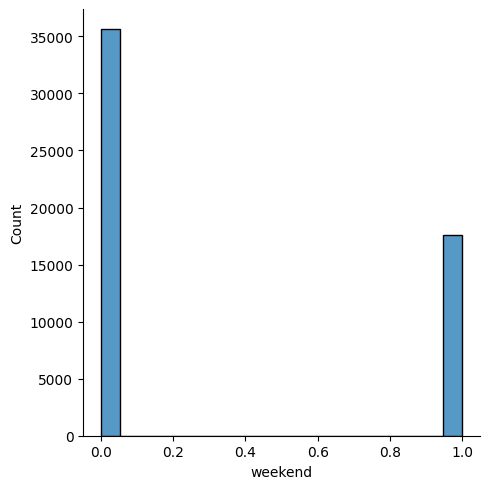

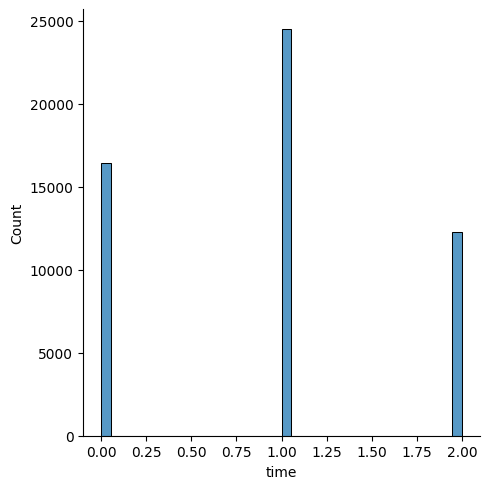

In [30]:
# weekend column
fil_df['weekend'] = pd.to_datetime(fil_df['timestamp']).dt.dayofweek
fil_df['weekend'] = fil_df['weekend'].apply(lambda x:0 if x<=4 else 1)

ch_sysef_df['weekend'] = fil_df['weekend']
sns.displot(data=ch_sysef_df, x="weekend")

# time column
def time_dec(x):
    if x<=12:
        t = 0
    elif x<=17:
        t = 1
    else:
        t = 2
    
    return t

fil_df['time'] = pd.to_datetime(fil_df['timestamp']).dt.hour
fil_df['time'] = fil_df['time'].apply(time_dec)

ch_sysef_df['time'] = fil_df['time']
sns.displot(data=ch_sysef_df, x="time")

## Training

In [31]:
# columns
ch_sysef_df.columns

Index(['index', 'ch_sysef', 'ch_run', 'h_cwst', 'h_cwrt', 'ct_tot_kw', 'lift',
       'sys_cl', 'wea_ct_wb', 'weekend', 'time'],
      dtype='object')

In [41]:
ch_sysef_df.weekend.isnull()

0          True
1          True
2          True
3          True
4          True
          ...  
176032    False
176033    False
176034    False
176035    False
176036    False
Name: weekend, Length: 176037, dtype: bool

In [35]:
ch_sysef_df.drop(['ch_sysef'], axis=1)

,index,ch_run,h_cwst,h_cwrt,ct_tot_kw,lift,sys_cl,wea_ct_wb,weekend,time
0,646,0,18.816253,23.172027,18.742946,57.418362,352.233795,9.572510,NaN,NaN
1,648,0,19.309412,22.277838,18.870598,56.349459,349.504547,9.642416,NaN,NaN
2,649,0,19.565208,22.588482,18.934530,59.801385,360.257111,9.646923,NaN,NaN
3,650,0,19.643861,22.829445,18.806738,62.487762,370.950195,9.625672,NaN,NaN
4,651,0,19.642947,22.889102,18.742950,64.045398,374.542725,9.646923,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
176032,727422,1,20.305983,22.166132,8.978951,67.121343,265.164551,9.643603,1.0,1.0
176033,727423,1,20.385087,22.333282,8.632043,69.247059,265.522705,9.648774,1.0,1.0
176034,727424,1,20.339091,22.288171,8.582858,68.338200,225.187408,9.648774,1.0,1.0
176035,727425,1,20.367607,22.181141,8.289721,67.035828,267.445557,9.651925,1.0,1.0


## Training Scripts

In [ ]:
rf = RandomForestRegressor(
    n_estimators=350,
    max_depth=80,
    min_samples_leaf=20,
    min_samples_split=20,
    random_state=10
    ) # hyperparameter values observed best to avoid both overfitting and underfitting

X = ch_sysef_df[['h_cwst', 'h_cwrt', 'ct_tot_kw', 'lift', 'sys_cl', 'wea_ct_wb', 'ch_run']]
y = ch_sysef_df[['ch_sysef']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
y.transpose()

rf.fit(X_train, y_train)

pickle.dump(rf, open('RF_all_feats.pkl', 'wb'))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


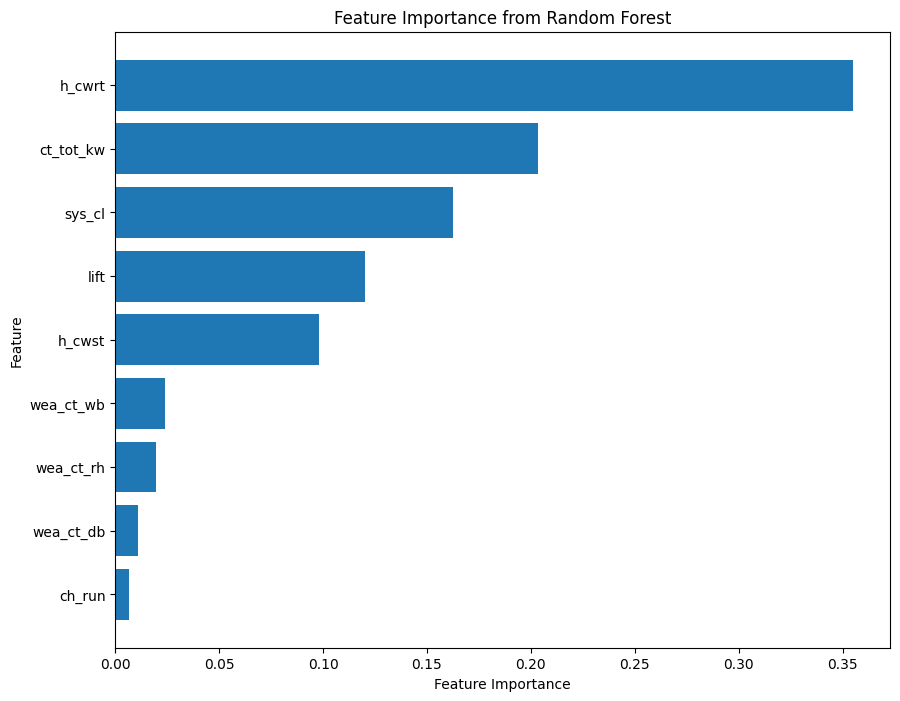

In [ ]:
feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# train test split
X = ch_sysef_df[['h_cwst', 'h_cwrt', 'ct_tot_kw', 'lift', 'sys_cl', 'wea_ct_wb', 'ch_run']]
y = ch_sysef_df[['ch_sysef']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
y.transpose()

# Training
max_depth = [100, 250, 500]
min_samples_splits = [10, 25, 50]
no_of_trees = [100, 200, 500]
min_samples_leafs = [10, 25, 50]


parameter_grid = {
    'regressor__max_depth': max_depth,
    'regressor__min_samples_split': min_samples_splits,
    'regressor__min_samples_leaf': min_samples_leafs,
    'regressor__n_estimators': no_of_trees,
    'regressor__random_state': [10],

}

# pipeline
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(
        warm_start=True,
        bootstrap=True,
        n_jobs=-1,
        max_features='sqrt'
    ))
])

grid_search = GridSearchCV(
    estimator= pipeline,
    param_grid=parameter_grid,
    cv=5
)

grid_search.fit(X_train, y_train)

## save model
filename = 'RF_all_feats.zy'
pickle.dump(grid_search, open(filename, 'wb'))

C:\Users\fabian\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\fabian\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\fabian\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\fabian\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be rem

In [ ]:
model = pickle.load(open("RF_all_feats.sav", 'rb'))
model.best_params_

{'regressor__max_depth': 100,
 'regressor__min_samples_leaf': 10,
 'regressor__min_samples_split': 10,
 'regressor__n_estimators': 500,
 'regressor__random_state': 10}

In [ ]:
grid_search.feature_importances_

In [ ]:
# train test split
X = ch_sysef_df[['h_cwst', 'h_cwrt', 'ct_tot_kw', 'lift', 'sys_cl', 'wea_ct_wb', 'ch_run']]
y = ch_sysef_df[['ch_sysef']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
y.transpose()

# Training
max_depth = [100, 500]
min_samples_splits = [10, 25, 50]
no_of_trees = [100, 200, 500]
min_samples_leafs = [10, 25, 50]


parameter_grid = {
    'regressor__max_depth': max_depth,
    'regressor__min_samples_split': min_samples_splits,
    'regressor__min_samples_leaf': min_samples_leafs,
    'regressor__n_estimators': no_of_trees,
    'regressor__random_state': [10],

}

# applya pca
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)

# pipeline
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(
        warm_start=True,
        bootstrap=True,
        n_jobs=-1,
        max_features='sqrt'
    ))
])

grid_search = GridSearchCV(
    estimator= pipeline,
    param_grid=parameter_grid,
    cv=5
)

grid_search.fit(X_train_pca, y_train)

## save model
filename = 'RF_all_feats_pca.sav'
pickle.dump(grid_search, open(filename, 'wb'))

C:\Users\fabian\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\fabian\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\fabian\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\fabian\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be rem

KeyboardInterrupt: 

In [ ]:
y_test.iloc[0]

ch_sysef    30.816478
Name: 11840, dtype: float64

In [ ]:
scaler_model = pickle.load(open(r"C:\Users\fabian\Desktop\optimization\optimization\parklane\RF_h_cwst_ct_approach_scaler.sav","rb"))
model = pickle.load(open(r"C:\Users\fabian\Desktop\optimization\optimization\parklane\RF_h_cwst_ct_approach.sav","rb"))

from sklearn.metrics import mean_squared_error

scaler_error = np.sqrt(mean_squared_error(y_test, scaler_model.predict(X_test)))
error = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))



FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\fabian\\Desktop\\optimization\\optimization\\parklane\\RF_h_cwst_ct_approach_scaler.sav'

In [ ]:
X_test.head(5)

,lift,sys_cl,ct_tot_kw,ch_run,h_cwst,ct_approach
11840,10614.664983,309.855560,18.806734,0,663.197385,6.278951
64524,13572.950031,343.521851,18.425098,0,738.867485,6.257807
139260,12768.529046,348.145447,14.287351,1,810.993181,3.229825
153388,12059.724581,339.590424,23.241098,1,811.481423,5.143402
76055,11024.036321,284.129730,13.997160,1,804.255682,2.906462


In [ ]:
y_test.head(5)

,ch_sysef
11840,30.816478
64524,44.545722
139260,37.227168
153388,34.785880
76055,27.552372


In [ ]:
np.log10(model.predict([[22.6**3, 376, 5**3, 1, 29.7**2, 1.6**1.5]]))/3

C:\Users\fabian\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([0.5833504])

# Models varied by season

RH > 90% AND DB < 26 C as rainy days 
RH < 85% AND DB > 30C as hot days
other conditions as normal days? 